# Using STDP to classify the MNIST dataset

In [31]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#machine Learning libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import utils
from snntorch import spikegen


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('snn_experiments'))
importlib.reload(importlib.import_module('snn_plot_utils'))
importlib.reload(importlib.import_module('snn_models'))

from snn_experiments import *
from snn_plot_utils import *
from snn_models import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)
print("Torch: ", torch.__version__)
print("Snntorch: ", snn.__version__) # version 0.6.4 before update, current version online 0.7.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4
Torch:  2.1.0
Snntorch:  0.6.4


# 1. Intro

## 1.1 Spotting correlated input with synaptic lif and external STDP class

Simulation time: 62.25 seconds


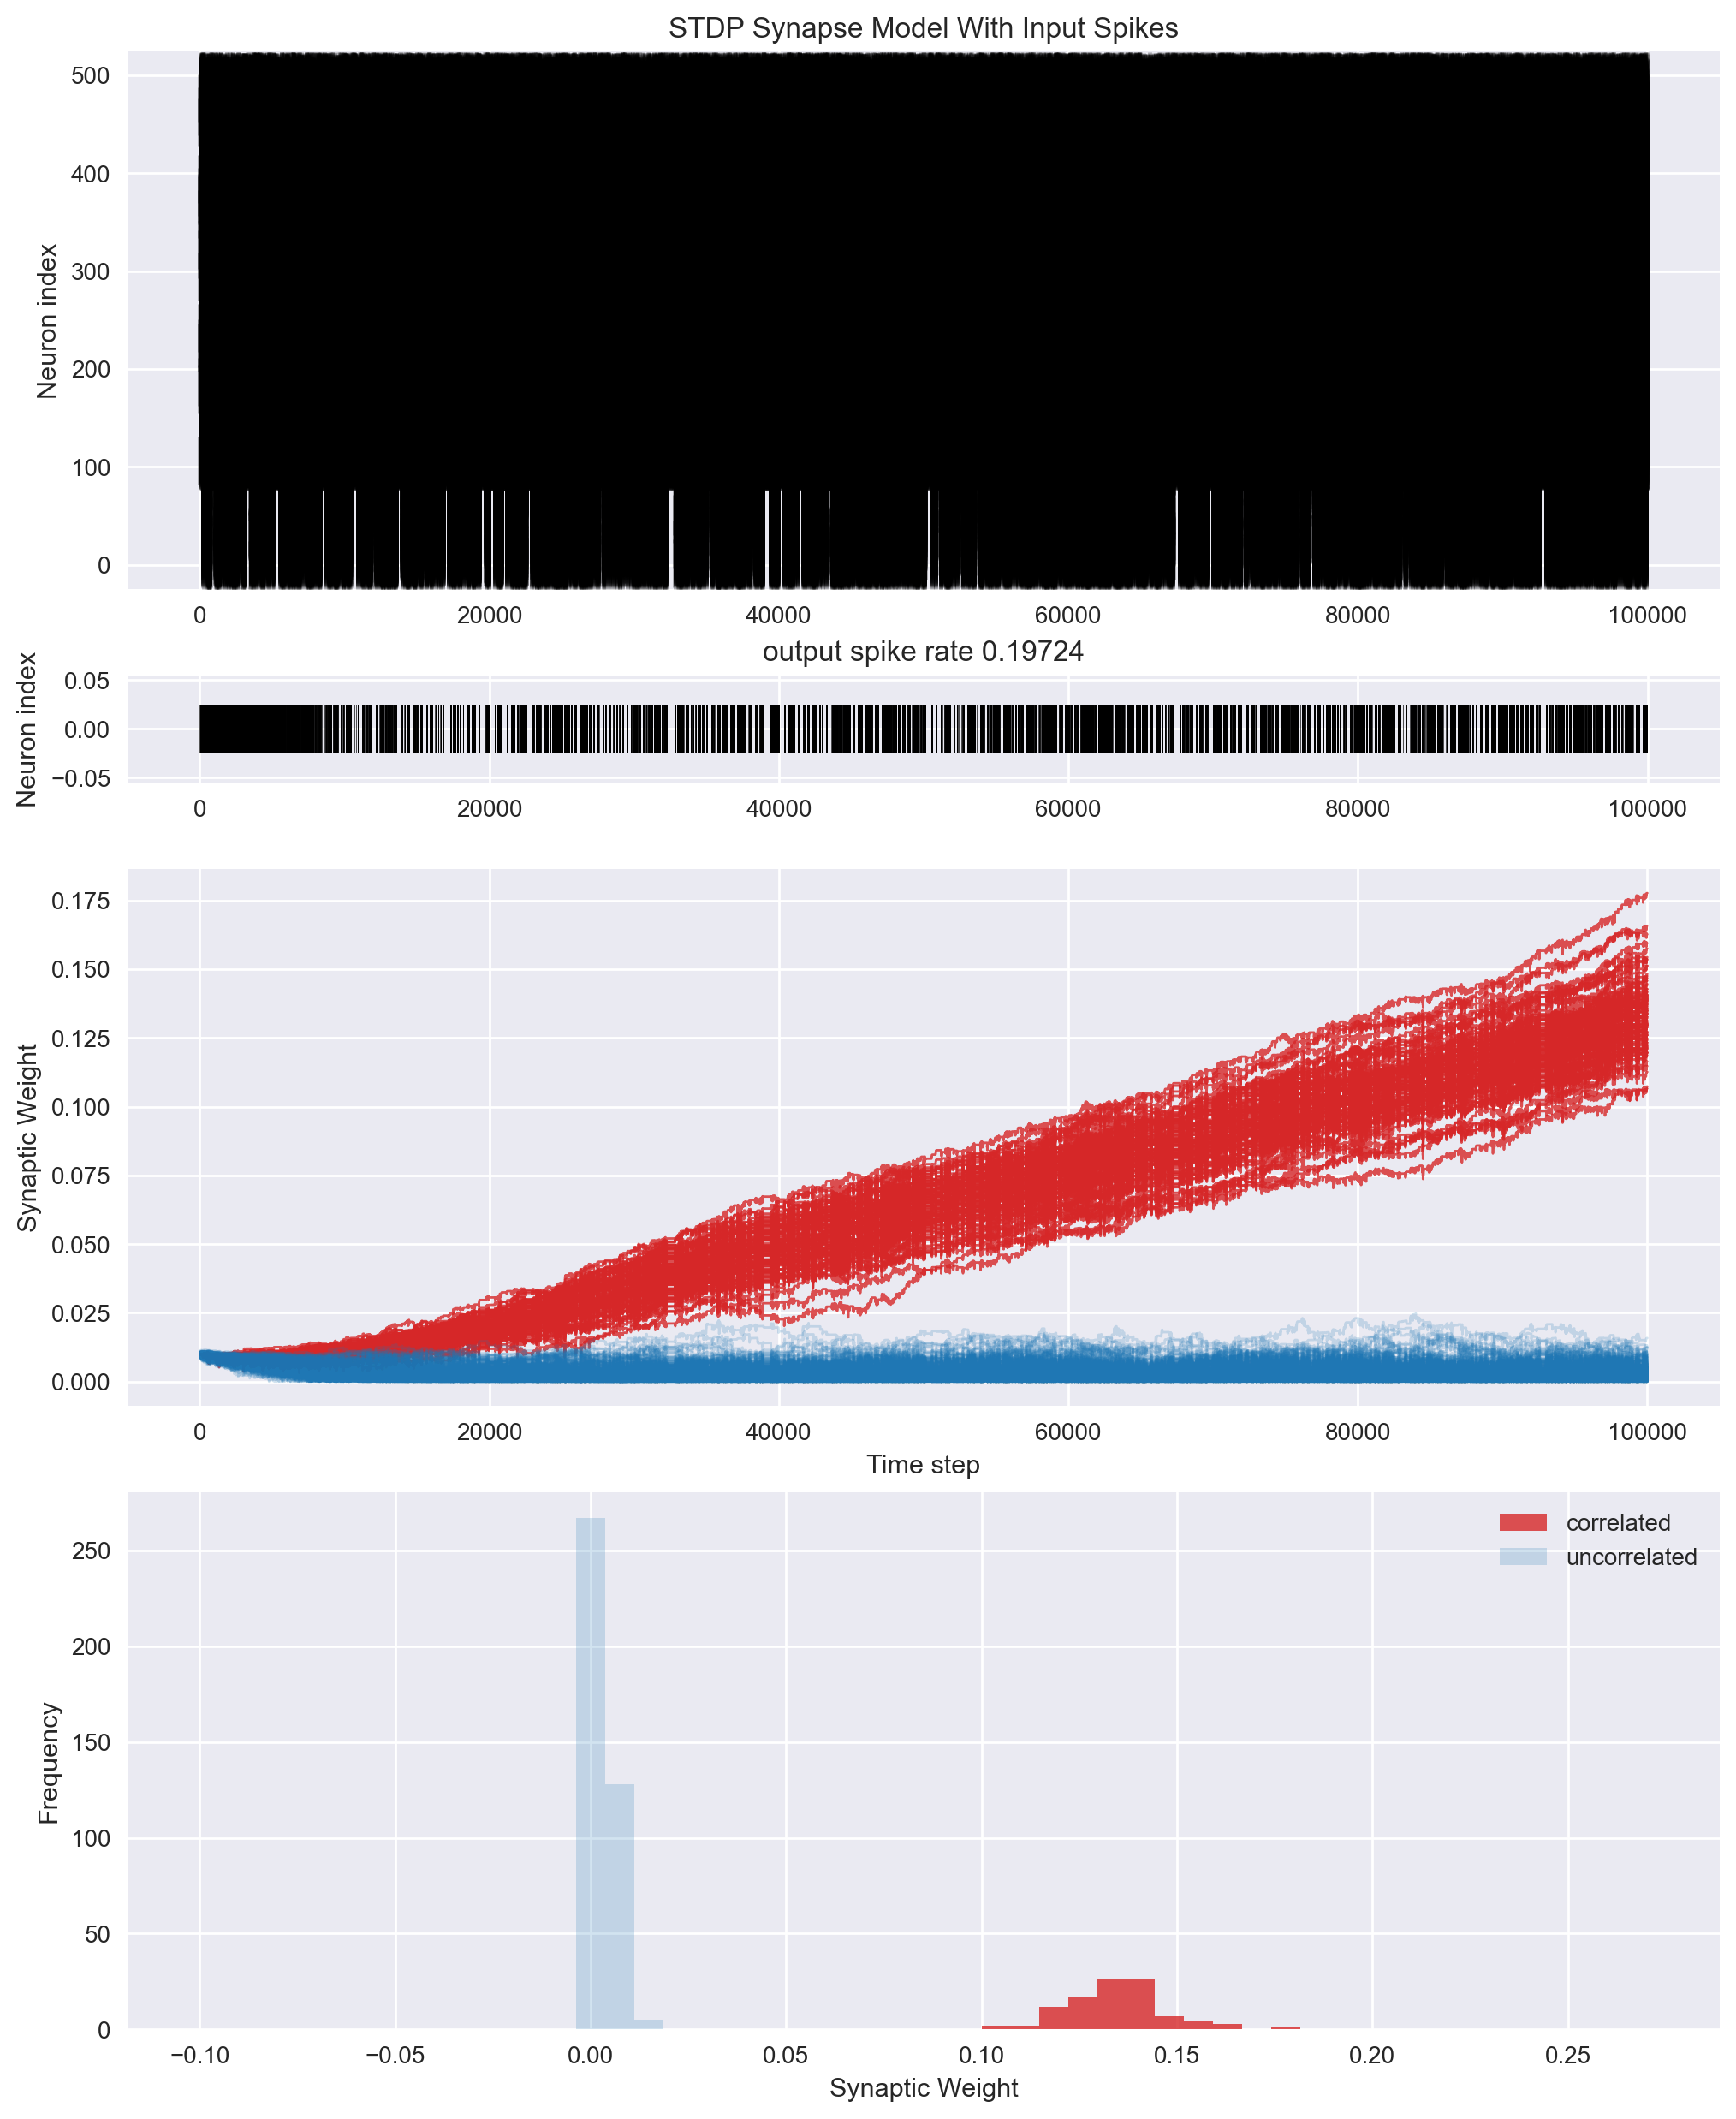

In [6]:
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,)
dt = pars['dt']
time_steps = np.arange(num_steps) * dt
rate = 0.01

# generate the injected spikes with some correlation
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-20,20]) 
cur_in = torch.from_numpy(cur_in_numpy)

# initialize the weights
W = np.random.rand(N_post, N_pre) * pars['w_init_value'] / 100
W = weight_initializer(pars, N_post, I=cur_in_numpy, type_init=2) * pars['w_init_value']  #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g'])) # or 0.8
alpha = np.exp(-pars['dt']/pars['tau_syn_exc']) #or 0.9
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
start_time = time.time()
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

print(f"Simulation time: {time.time() - start_time:.2f} seconds")

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

weight_history = my_synapses.get_records()['W'][1:,0,:]
plot_raster_weight_distr(cur_in, spk_record, weight_history, N_pre_correlated)



## 1.2 Spotting correlated input with an SNN with 1 FC layer, Synaptic Neuron, classic STDP

Forward pass time : --- 64.67 seconds ---


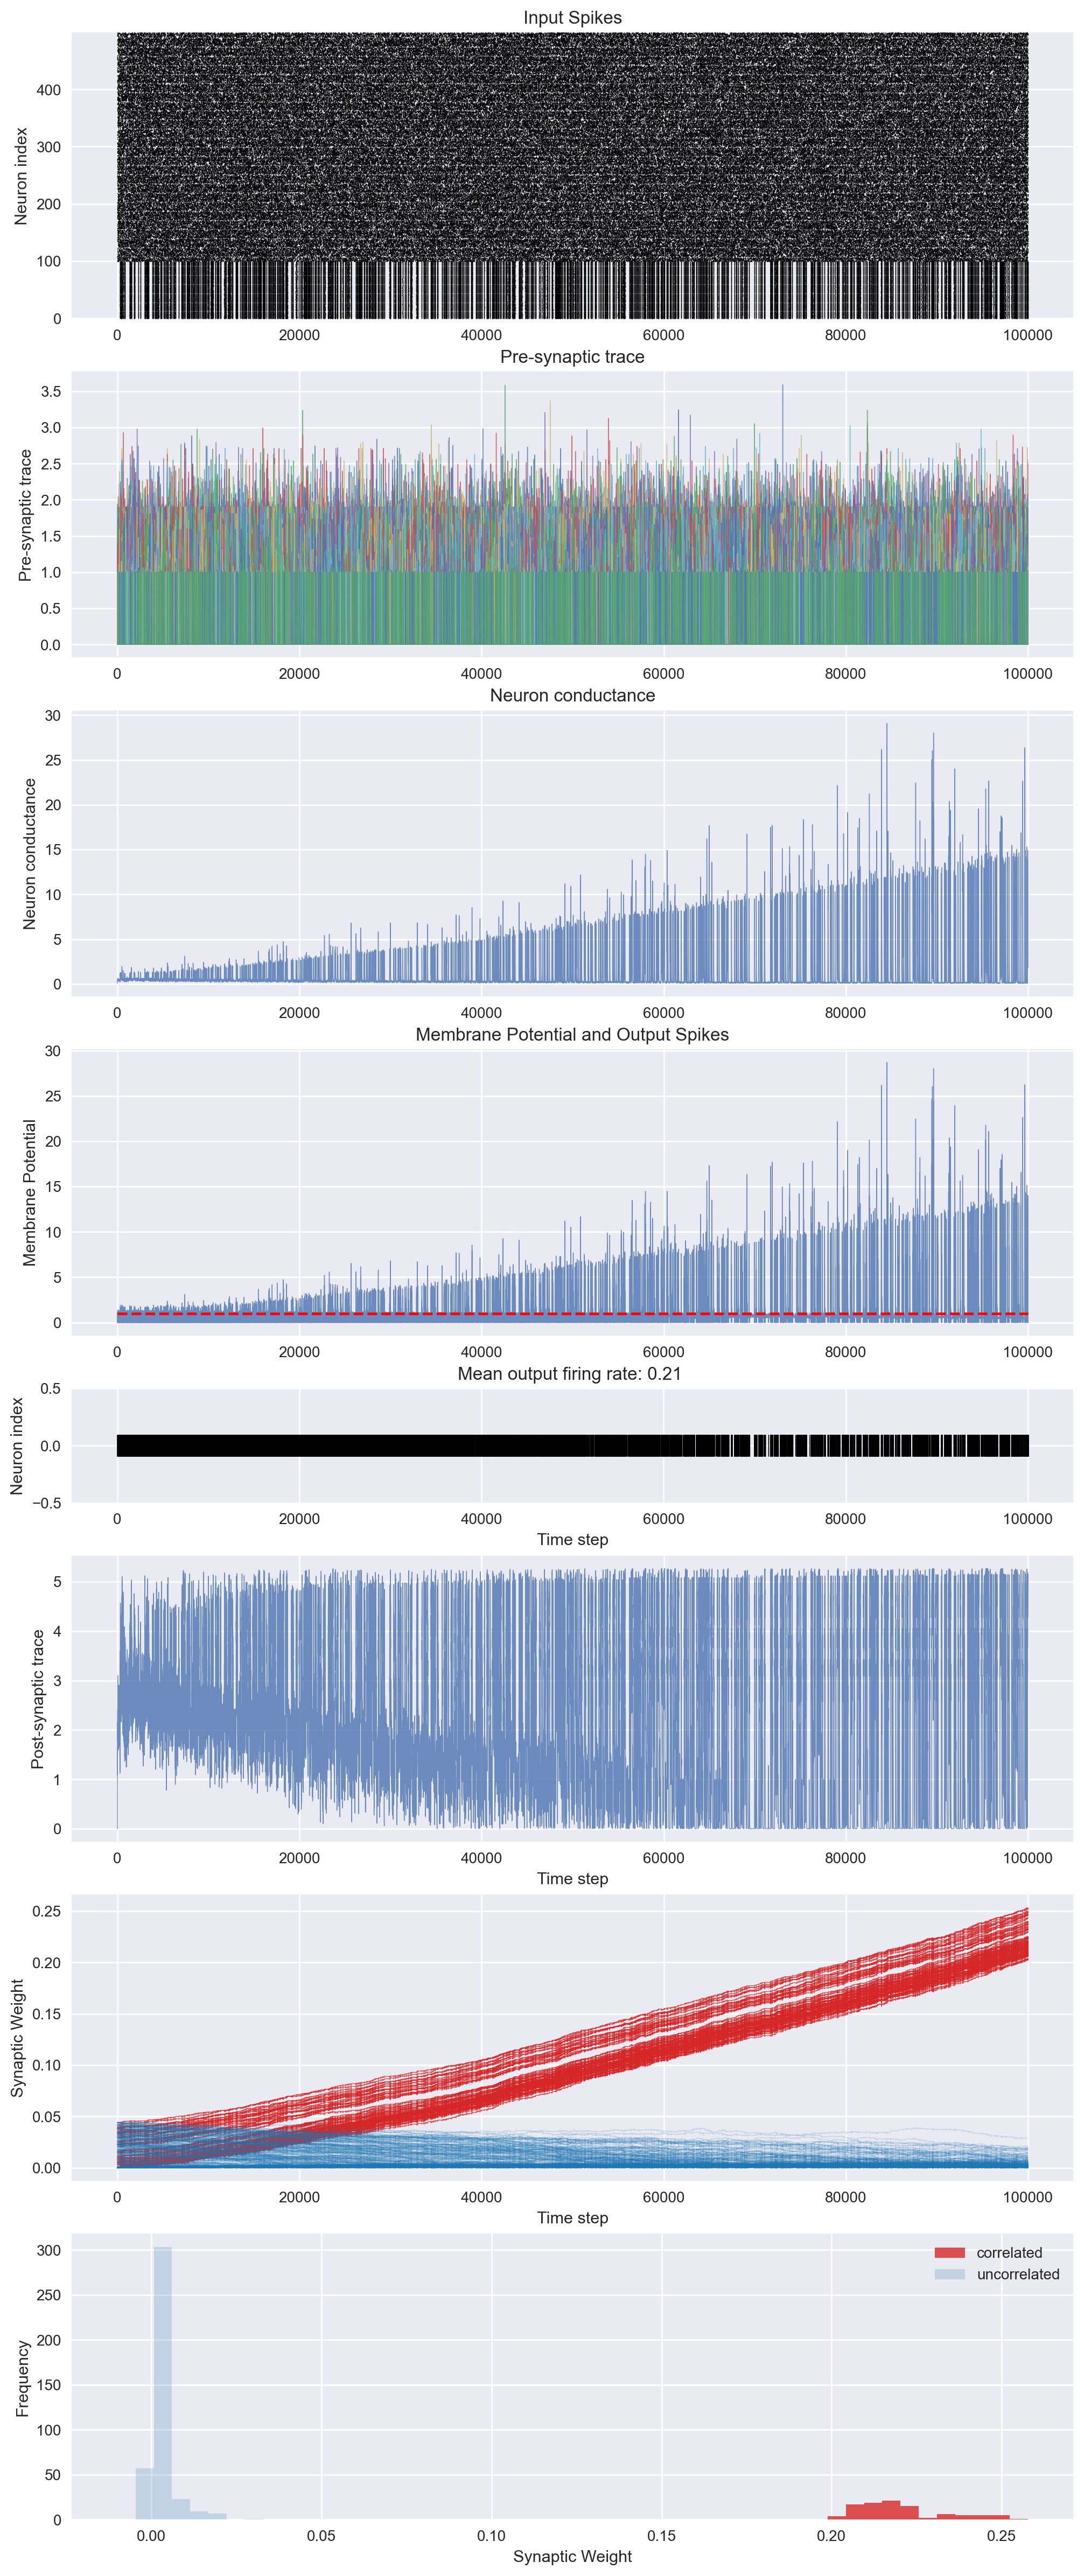

In [10]:
# basic variables
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000
batch_size = 0 # for the moment we do not use batch size
rate = 0.01

class synaptic_stdp(nn.Module):

    def __init__(self, pars, N_pre, N_post = 1):
        super(synaptic_stdp, self).__init__()
        self.pars = pars
        self.alpha = pars.get('alpha', 0.9)
        self.beta = pars.get('beta', 0.8)
        self.w_max = pars.get('w_max', 1.0)
        self.w_min = pars.get('w_min', 0.0)
        self.fc = nn.Linear(N_pre, N_post, bias=False)
        # clamp the weight to positive values
        self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)
        # set the weight of the layer
        #W_init = weight_initializer(pars, N_pre, N_post, type_init = 3, tensor = True)
        #self.fc.weight = nn.Parameter(W_init)
        reset_mechanism = 'zero' if pars['hard_reset'] else 'subtract'
        self.lif = snn.Synaptic(alpha = self.alpha, beta = self.beta, threshold = pars['threshold'], reset_mechanism = reset_mechanism)

    def forward(self, x):
        # initiliaze the membrane potential and the spike
        cond, mem = self.lif.init_synaptic()

        #tracking variables
        mem_rec = []
        spk_rec = []
        cond_rec = []
        # dovrei inizializzare tutto o come liste o come tensori...
        pre_syn_traces = generate_traces(self.pars, x)
        post_syn_traces = torch.zeros((x.shape[0]+1, N_post))
        weight_history = torch.zeros((x.shape[0]+1, N_post, N_pre))
        weight_history[0,:,:] = self.fc.weight.data

        for step in range(x.shape[0]):
            # run the fc layer
            cur_step = self.fc(x[step])
            # run thw lif neuron
            spk, cond,  mem = self.lif(cur_step, cond, mem)

            # store the membrane potential and the spike
            mem_rec.append(mem)
            spk_rec.append(spk)
            cond_rec.append(cond)

            # updatae post synaptic traces
            beta_minus = self.pars.get('beta_minus',0.9)
            post_syn_traces[step+1, :] = beta_minus*post_syn_traces[step, :] + spk

            # update the weights
            weight_history[step,:,:] = self.fc.weight.data
            A_plus, A_minus = self.pars['A_plus'], self.pars['A_minus']
            LTP = A_plus * torch.outer(spk, pre_syn_traces[step,:]) 
            LTD = A_minus * torch.outer(post_syn_traces[step+1,:], x[step])
            self.fc.weight.data = self.fc.weight.data + LTP - LTD
            # hard constrain on the weights
            self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)


        post_syn_traces = post_syn_traces[:-1,:]
        weight_history = weight_history[:-1,:,:]

        self.records = {'mem': torch.stack(mem_rec), 
                        'spk': torch.stack(spk_rec), 
                        'cond':  torch.stack(cond_rec), 
                        'pre_trace': pre_syn_traces, 
                        'post_trace': post_syn_traces, 
                        'W': weight_history}

        return 
    
    



# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.012,
                    alpha = 0.9,
                    beta = 0.8,
                    threshold = 1.0,
                    hard_reset = True,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,
                    beta_minus = 0.9,
                    beta_plus = 0.9)
dt = pars['dt']

# generate the input spikes
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
cur_in = torch.from_numpy(cur_in_numpy)
cur_in = cur_in.to(dtype = torch.float32, device = device)

# intitilize the model
my_model = synaptic_stdp(pars, N_pre, N_post)

# run the simulation
#my_model.train()
start_time = time.time()
my_model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")
mem_rec, spk_rec, cond_rec, pre_trace, post_trace, weight_history = my_model.records['mem'], my_model.records['spk'], my_model.records['cond'], my_model.records['pre_trace'], my_model.records['post_trace'], my_model.records['W']

# plot results
plot_results_32(dt, cur_in, pre_trace, cond_rec, mem_rec, spk_rec, post_trace, weight_history, N_pre, N_pre_correlated, N_post, num_steps)


# 2. Digit recognition

## 2.1 MNIST encoding in spike trains

In [16]:
# Training Parameters
data_path=r'C:\Users\latta\GitHub\STDP-research\data'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

# define the transformation
transform = transforms.Compose([
            transforms.Resize((784,1)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,)),
            transforms.Lambda(lambda x: torch.squeeze(x)),
])
# download the MNIST dataset
train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Split the train dataset into train and validation sets
train_size = 50000
val_size = 10000
test_size = 10000

indices = torch.randperm(len(train_dataset)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]

# Create data loaders for train, validation, and test sets
batch_size = 3
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_indices))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

# Checking the sizes of datasets
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# extract a subset for preliminary experiments
subset = 100 # ratio of the original dataset
mnist_subset = utils.data_subset(train_dataset, subset)
print(f"The size of mnist_subset is {len(mnist_subset)}")
subset_loader = DataLoader(mnist_subset, batch_size=batch_size, shuffle=True)

# Iterate through minibatches
data = iter(subset_loader)
data_it, targets_it = next(data)

# Spiking Data
num_steps = 100
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain = 1)

print(f'Size of a batch of spike data is {spike_data.size()}')

Train set size: 60000
Validation set size: 60000
Test set size: 10000
The size of mnist_subset is 600
Size of a batch of spike data is torch.Size([100, 3, 784])


In [78]:
# Create a costum class dataset with determinsitic spike rate encoding from the previous ones

class rate_encoded_mnist(torch.utils.data.Dataset):

    def __init__(self, batch_size, num_steps=100, gain=1, train=True, data_path=r'.\data', my_seed=42):

        self.batch_size = batch_size
        self.num_steps = num_steps
        self.gain = gain
        # define the transformation
        transform = transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.Grayscale(),
                    transforms.ToTensor(),
                    transforms.Normalize((0,), (1,)),
                    transforms.Lambda(lambda x: torch.squeeze(x)),
        ])
        my_generator = torch.Generator(device='cpu')
        my_generator.manual_seed(my_seed)
        self.my_generator = my_generator
        self.train = train
        self.dataset = datasets.MNIST(data_path, train=train, download=True, transform=transform)
        # divide the data from the targets
        self.data = self.dataset.data
        self.targets = self.dataset.targets

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_sample, target = self.dataset[idx]
        data_sample = self.rate_encode(data_sample, num_steps=self.num_steps, gain = self.gain)
        return data_sample, target
    
    def rate_encode(self, data_sample, num_steps, gain):
        data_sample = data_sample.view(-1)
        data_sample = data_sample*gain
        data_sample = torch.clamp(data_sample, 0, 1)
        data_sample = data_sample.repeat(num_steps,1)
        data_sample = torch.bernoulli(data_sample, generator=self.my_generator)
        return data_sample
    
    def visualize_rate_image(self, idx):
        data_sample, target = self.dataset[idx]
        data_sample = self.rate_encode(data_sample, num_steps=self.num_steps, gain = self.gain)
        data_sample = data_sample.view(self.num_steps, 28, 28)  # Reshape the data to match the desired shape
    
        # little animation to visualize an example of the spike data
        fig, ax = plt.subplots()
        # plot the animation
        anim = splt.animator(data_sample, fig, ax)
        print(f"The corresponding target is: {target}")

        # If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
        anim.save(f"Spike_rate_encoding_of_an_{target}.mp4")
        return
    
    def custom_collate_fn(self, batch):
        #C REATE THE BATCH ALONG THE RIGHT DIMENSION
        # batch is a list of (data, target) tuples
        # data: num_steps x 28 x 28 tensor
        # target: scalar tensor
        
        # Stack data tensors along a new dimension (axis=0)
        data_batch = torch.stack([item[0] for item in batch], dim=1)
        
        # Stack target tensors along a new dimension (axis=0)
        target_batch = torch.stack([torch.tensor(item[1]) for item in batch], dim=0)
        
        return data_batch, target_batch

    def get_loader(self):
        if self.train:
            # Split the train dataset into train and validation sets
            train_size = 50000
            val_size = 10000
            indices = torch.randperm(len(self.dataset), generator=self.my_generator).tolist()
            train_indices = indices[:train_size]
            val_indices = indices[train_size:train_size+val_size]
            train_sampler = torch.utils.data.SubsetRandomSampler(train_indices, generator=self.my_generator)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_indices, generator=self.my_generator)
            train_loader = torch.utils.data.DataLoader(dataset=self, batch_size = self.batch_size, sampler=train_sampler, collate_fn=self.custom_collate_fn)
            val_loader = torch.utils.data.DataLoader(dataset=self, batch_size = self.batch_size, sampler=val_sampler, collate_fn=self.custom_collate_fn)
            return train_loader, val_loader
        elif not self.train:
            test_loader = torch.utils.data.DataLoader(dataset=self, batch_size = self.batch_size, shuffle=False, collate_fn=self.custom_collate_fn)
            return test_loader
        
    def get_subset(self, subset=100):
        mnist_subset = utils.data_subset(self, subset)
        subset_loader = DataLoader(mnist_subset, batch_size=self.batch_size, shuffle=True, collate_fn=self.custom_collate_fn)
        return subset_loader
        
        
batch_size = 50
num_steps = 100

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=1, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=1, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()

# get the subset loader
subset_loader = mnist_train.get_subset(subset=100)

# check the shape in the loaders and the loader length
data = iter(train_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the train_loader is {len(train_loader)}")

# check the shape in the subset loader and the loader length
data = iter(subset_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the subset_loader is {len(subset_loader)}")


Size of a batch of spike data is torch.Size([100, 50, 784])
Length of the train_loader is 1000
Size of a batch of spike data is torch.Size([100, 50, 784])
Length of the subset_loader is 12


## 2.2 Some preliminaries 

### Check all the components of the net

In [2]:
num_steps = 100
N_pre = 100
N_pre_correlated = 10
rate = 0.05
dt = 1
N_post = 2

pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.002 ,
    A_plus = 0.001 ,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.5,
    refractory_period = True,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
)

model = snn_mnist(pars, N_pre, N_post)
model.eval()


cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
# add a batch dimension to cur_in_numpy
cur_in_numpy = cur_in_numpy[:,None,:]
cur_in = torch.from_numpy(cur_in_numpy)
cur_in = cur_in.to(dtype = torch.float32, device = device)


start_time = time.time()
model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")

# plot the results
model.plot_neuron_records()

fig, ax = plt.subplots(2, figsize=(12,6), gridspec_kw = {'height_ratios': [1, 1]})
time_steps = np.arange(num_steps) * dt
lw = max(100/num_steps, 0.5)

# plot of the weights evolution
W = torch.stack(model.synapse_records['W']).detach().numpy()[:,0,:]
cor_weights = pd.DataFrame(W[:, :N_pre_correlated])
uncor_weights = pd.DataFrame(W[:, N_pre_correlated:])
cor_weights.plot(ax = ax[0], legend = False, color = 'tab:red', alpha = 0.8, lw = lw)
uncor_weights.plot(ax = ax[0], legend = False, color = 'tab:blue', alpha = 0.2, lw = lw)
ax[0].set_ylabel("Synaptic Weight")
ax[0].set_xlabel("Time step")

# plot the final weights distribution
time_step = -1
w_min = np.min(W[time_step,:])-0.01
w_max = np.max(W[time_step,:])+0.01
width = (w_max - w_min)/51
bins = np.arange(w_min, w_max, width)
ax[1].hist(W[time_step,:N_pre_correlated], bins = bins, color = 'tab:red', alpha = 0.8, label = 'correlated')
ax[1].hist(W[time_step,N_pre_correlated:], bins = bins, color = 'tab:blue', alpha = 0.2, label = 'uncorrelated')
ax[1].set_xlabel("Synaptic Weight")
ax[1].set_ylabel("Frequency")
ax[1].legend(loc = 'best')

plt.show()


AttributeError: 'snn_mnist' object has no attribute 'new_post_syn_traces'

### Class assignment function


In [ ]:
num_epochs = 2
num_steps = 100
min_spk_number = 1
pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.0088 ,
    A_plus = 0.008 ,
    reset_mechanism = 'subtract',
    dynamic_threshold = False,
    tau_theta = 5, 
    theta_add = 0.1,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 1,
    gain = 0.1,
)
N_pre = 28*28
N_post = 25
model = snn_mnist(pars, N_pre, N_post)

assignments, df = assign_neurons_to_classes(model, data_val = subset_loader, my_seed = 42)

print(assignments)
display(df)


Processing batch 0 --- 0.00 seconds ---
Processing batch 100 --- 4.54 seconds ---
{'neuron_0': 0, 'neuron_1': 0, 'neuron_2': 0, 'neuron_3': 0, 'neuron_4': 0, 'neuron_5': 0, 'neuron_6': 0, 'neuron_7': 0, 'neuron_8': 0, 'neuron_9': 0, 'neuron_10': 0, 'neuron_11': 0, 'neuron_12': 0, 'neuron_13': 0, 'neuron_14': 0, 'neuron_15': 0, 'neuron_16': 0, 'neuron_17': 0, 'neuron_18': 0, 'neuron_19': 0, 'neuron_20': 0, 'neuron_21': 0, 'neuron_22': 0, 'neuron_23': 0, 'neuron_24': 0}


,0,1,2,3,4,5,6,7,8,9,max index
neuron_0,0.874655,0.454684,0.798281,0.797966,0.617627,0.651569,0.747778,0.663871,0.806327,0.643077,0
neuron_1,0.846034,0.416962,0.754219,0.760847,0.583390,0.606078,0.704074,0.603710,0.762449,0.596769,0
neuron_2,0.803966,0.389494,0.724219,0.687797,0.564407,0.545294,0.681852,0.562258,0.707551,0.553846,0
neuron_3,0.868448,0.450633,0.803750,0.786610,0.614746,0.649412,0.782037,0.620968,0.789184,0.631846,0
neuron_4,0.879828,0.457848,0.798437,0.822881,0.619661,0.663529,0.752222,0.655806,0.817755,0.657538,0
neuron_5,0.870000,0.465190,0.799844,0.806610,0.659322,0.635098,0.771667,0.633548,0.818571,0.636308,0
neuron_6,0.853966,0.429873,0.766719,0.773898,0.603729,0.622941,0.735000,0.624194,0.780000,0.624154,0
neuron_7,0.870862,0.455570,0.795000,0.812034,0.622881,0.648431,0.755926,0.617581,0.811837,0.640462,0
neuron_8,0.841034,0.413924,0.774531,0.754915,0.581864,0.588824,0.731852,0.548226,0.753265,0.566462,0
neuron_9,0.849138,0.425190,0.767969,0.765085,0.595424,0.594902,0.721296,0.581935,0.778980,0.589231,0


### Evaluation Function

In [ ]:
# modify the assignments to have random classes
for i in range(N_post):
    assignments[f'neuron_{i}'] = np.random.randint(0, 9)

test_accuracy = classify_test_set(model, subset_loader, assignments, my_seed = 42)

display(test_accuracy)

Processing batch 0 --- 0.00 seconds ---
Processing batch 100 --- 4.40 seconds ---


0.08666666666666667

### Training function

In [4]:
# gets all the target from the subset_loader
targets = torch.tensor([])
for data, target in subset_loader:
    targets = torch.cat((targets, target))

targets = targets.numpy()

# print the ratio of most represented class
most_represented_class = np.argmax([np.sum(targets == i) for i in range(10)])
print(f"The most represented class has a ratio of {np.sum(targets == most_represented_class)/len(targets)} and is class {most_represented_class}")

The most represented class has a ratio of 0.13166666666666665 and is class 1


In [46]:
num_epochs = 2
num_steps = 10
test_num_steps = 10
min_spk_number = 1
pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.00011,
    A_plus = 0.0001 ,
    reset_mechanism = 'zero',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.25,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
    gain = 0.1,
    test_num_steps = test_num_steps,
    use_min_spk_number = False,
)
N_pre = 28*28
N_post = 10
model = snn_mnist(pars, N_pre, N_post)

# Train the model
start_time = time.time()
model = train_model(model, 
                    data_train = subset_loader, 
                    data_val = subset_loader,
                    num_epochs = num_epochs, 
                    min_spk_number = 1, 
                    num_steps = num_steps, 
                    )
print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
#print(f"The size of records_full is {sys.getsizeof(records_full)/1e3:.2f} KB")

"""
fig, ax = plt.subplots(3, figsize=(12,10), gridspec_kw = {'height_ratios': [1, 1, 1]})
time_steps = np.arange(num_steps) * pars['dt']
lw = max(min(100/num_steps,1), 0.5)

# plot of the weights evolution
W1 = np.concatenate([records_full[f'epochs_{num_epochs-1}'][f'image_{i}'][:,0,:] for i in range(len(subset_loader))], axis = 0 )
W1 = torch.stack(model.W_history).detach().numpy()[:,0,:]
check_number = 10
ax[0].plot( W1[:,check_number:], color = 'blue', alpha = 0.05, lw = lw)
ax[0].plot( W1[:,:check_number], color = 'red', alpha = 1., lw = lw)
ax[0].set_ylabel("Synaptic Weight")
ax[0].set_xlabel("Time step")


# plot the final weights distribution
time_step = -1
w_min = np.min(W1[time_step,:])-0.01
w_max = np.max(W1[time_step,:])+0.01
width = (w_max - w_min)/51
bins = np.arange(w_min, w_max, width)
ax[1].hist(W1[time_step,:], bins = bins, color = 'tab:blue', alpha = 0.2, label = 'uncorrelated')
ax[1].set_xlabel("Synaptic Weight")
ax[1].set_ylabel("Frequency")
ax[1].legend(loc = 'best')


W2 = np.concatenate([records_full[f'epochs_{num_epochs-1}'][f'image_{i}'][:,1,:] for i in range(len(subset_loader))], axis = 0 )
ax[2].plot( W2[:,check_number:], color = 'blue', alpha = 0.05, lw = lw)
ax[2].plot( W2[:,:check_number], color = 'red', alpha = 1., lw = lw)
ax[2].set_ylabel("Synaptic Weight")
ax[2].set_xlabel("Time step")


plt.show()"""


100%|█████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.24batch/s, accuracy=0.0967, time=9.42s]

 The total training time is 16.25 seconds


'\nfig, ax = plt.subplots(3, figsize=(12,10), gridspec_kw = {\'height_ratios\': [1, 1, 1]})\ntime_steps = np.arange(num_steps) * pars[\'dt\']\nlw = max(min(100/num_steps,1), 0.5)\n\n# plot of the weights evolution\nW1 = np.concatenate([records_full[f\'epochs_{num_epochs-1}\'][f\'image_{i}\'][:,0,:] for i in range(len(subset_loader))], axis = 0 )\nW1 = torch.stack(model.W_history).detach().numpy()[:,0,:]\ncheck_number = 10\nax[0].plot( W1[:,check_number:], color = \'blue\', alpha = 0.05, lw = lw)\nax[0].plot( W1[:,:check_number], color = \'red\', alpha = 1., lw = lw)\nax[0].set_ylabel("Synaptic Weight")\nax[0].set_xlabel("Time step")\n\n\n# plot the final weights distribution\ntime_step = -1\nw_min = np.min(W1[time_step,:])-0.01\nw_max = np.max(W1[time_step,:])+0.01\nwidth = (w_max - w_min)/51\nbins = np.arange(w_min, w_max, width)\nax[1].hist(W1[time_step,:], bins = bins, color = \'tab:blue\', alpha = 0.2, label = \'uncorrelated\')\nax[1].set_xlabel("Synaptic Weight")\nax[1].set_ylabel

In [47]:
print(f'the forward count is {model.forward_count}')
print(f'the batch size is {batch_size}')
print(f'the num steps is {num_steps}')

# check that the records have all the correct shapes
records = model.get_records()
for key in records.keys():
    print(f'{key} has shape {records[key].shape}')

the forward count is 400
the batch size is 3
the num steps is 10
mem has shape (12000, 10)
spk has shape (12000, 10)
syn has shape (12000, 10)
threshold has shape (12000, 10)
pre_trace has shape (12000, 784)
post_trace has shape (12000, 10)
W has shape (4000, 10, 784)


In [48]:
# see the assigned classes
assignments, df = assign_neurons_to_classes(model, data_val = subset_loader, my_seed = 42)
display(df)

Processing batch 0 --- 0.00 seconds ---
Processing batch 100 --- 0.79 seconds ---


,0,1,2,3,4,5,6,7,8,9,max index
neuron_0,0.239655,0.079747,0.220313,0.211864,0.147458,0.170588,0.220370,0.140323,0.206122,0.149231,0
neuron_1,0.229310,0.054430,0.210938,0.206780,0.105085,0.154902,0.211111,0.124194,0.232653,0.116923,8
neuron_2,0.203448,0.043038,0.187500,0.172881,0.108475,0.127451,0.194444,0.156452,0.234694,0.106154,8
neuron_3,0.218966,0.059494,0.203125,0.194915,0.147458,0.168627,0.211111,0.151613,0.220408,0.150769,8
neuron_4,0.241379,0.060759,0.204688,0.194915,0.128814,0.147059,0.187037,0.124194,0.222449,0.123077,0
neuron_5,0.227586,0.048101,0.198438,0.205085,0.111864,0.149020,0.201852,0.127419,0.212245,0.113846,0
neuron_6,0.220690,0.077215,0.200000,0.184746,0.116949,0.131373,0.201852,0.112903,0.232653,0.135385,8
neuron_7,0.206897,0.060759,0.203125,0.171186,0.128814,0.127451,0.203704,0.104839,0.191837,0.129231,0
neuron_8,0.210345,0.049367,0.225000,0.184746,0.120339,0.129412,0.190741,0.135484,0.216327,0.129231,2
neuron_9,0.237931,0.039241,0.195313,0.201695,0.098305,0.168627,0.200000,0.127419,0.208163,0.123077,0


## 2.3 Training

In [ ]:
# to be done
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

##